# Multivariate Time Series forecast using seq2seq in TensorFlow

This notebook implements the cast study of applying seq2seq model for time series data. 

The purpose is to showcase the effectiveness of seq2seq to learn the true patterns under the noisy signals. In addition, we are able to implement models with flexibility such as: 

- Variable input and output sequence lengths
- Variable numbers of input and output signals 

This tutorial is divided into four parts - first we will be demonstrating how to train a basicseq2seq model on univariate data. The model is then easily applied to multivariate cases. We will then discuss about situation with outliers. And finally, we will showcase a real-world dataset to forecast pollution (pm2.5) in Beijing. 

To see the comprehensive explanations of each step, can jump to the post associated with this study - 
weiminwang.blog/2017/09/29/multivariate-time-series-forecast-using-seq2seq-in-tensorflow/

This is a long notebook - you can choose the session of your interests by clicking on the links below: 

## Contents

### 1) <b>[Univariate time series](#session1)</b> 

### 2) <b>[Multivariate time series](#session2)</b> 

### 3) <b>[Seq2seq for outliers/extreme events](#session3)</b> 

### 4) <b>[A case study - Beijing pollution data](#session4)</b> 
data credits go to UCI - https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

<a id='session1'></a>
# Univariate time series

In [16]:
import tensorflow as tf
import numpy as np 
import random
import math
from matplotlib import pyplot as plt
import os
import copy
import pandas as pf
import pandas as pd

<a id='session2'></a>
# Multivariate time series: 


### Input sequences

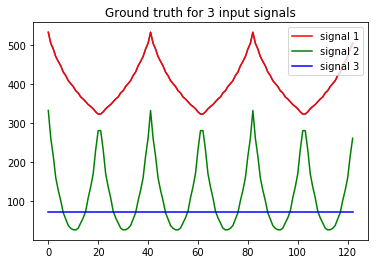

In [22]:
x = np.linspace(0, 40, 130)
x1 = 2 * np.sin(x)
x2 = 2 * np.cos(x)
#sin, cos
pf = pd.read_csv("log.csv")
cols = ['X0','Y0','A']

y1 = pf[cols[0]]
y2 = pf[cols[1]]
y3 = pf[cols[2]]
plt.plot(pf[cols[0]])

plt.title("Ground truth for 3 input signals")
l1, = plt.plot(y1, 'r', label = 'signal 1')
l2, = plt.plot(y2, 'g', label = 'signal 2')
l3, = plt.plot(y3, 'b', label = 'signal 3')

plt.legend(handles = [l1, l2, l3], loc = 'upper right')

plt.show()

### Both input and output sequences

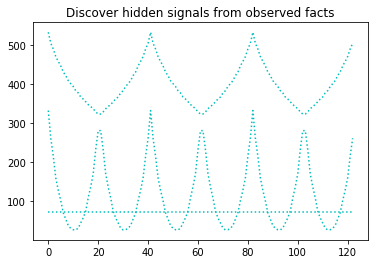

In [23]:
x = np.linspace(0, 40, 130)
x1 = 2 * np.sin(x)
x2 = 2 * np.cos(x)

y1 = y1
y2 = y2
y3 = y3

plt.title("Discover hidden signals from observed facts")
l1, = plt.plot(y1, 'c:', label = 'input signals (observed facts)')
plt.plot(y2, 'c:')
plt.plot(y3, 'c:')

#l4, = plt.plot(2 * x1, 'm', label = 'output signals (hidden signals)')
#plt.plot(2 * x2, 'm') # multiplies by 2 just for visualization purpose

#plt.legend(handles = [l1, l4], loc = 'upper right')

#plt.show()

## Create function that generates training samples

In [24]:
#INPUT SEQ LEN MUST BE EQUAL TO THE AMOUNT OF ROWS MINUS THE HEADER
input_seq_len = 123
output_seq_len = 150
x = np.linspace(0, 40, 130)
#train_data_x = x[:125]
train_data_x = x[:(130 - output_seq_len)]
#110

def true_output_signals(x):
    x1 = 2 * np.sin(x)
    x2 = 2 * np.cos(x)
    return x1, x2

def true_input_signals(x):
    x1, x2 = true_output_signals(x)
    y1 = pf[cols[0]]
    y2 = pf[cols[1]]
    y3 = pf[cols[2]]
    return y1, y2, y3

def noise_func(x, noise_factor = 2):
    return np.random.randn(len(x)) * noise_factor

def generate_samples_for_output(x):
    x1, x2 = true_output_signals(x)
    return x1+noise_func(x1, 0.5), \
           x2+noise_func(x2, 0.5)

def generate_samples_for_input(x):
    y1, y2, y3 = true_input_signals(x)
    return y1+noise_func(y1, 2), \
           y2+noise_func(y2, 2), \
           y3+noise_func(y3, 2)

def generate_train_samples(x = train_data_x, batch_size = 10):

    total_start_points = len(x) - input_seq_len - output_seq_len
    start_x_idx = np.random.choice(range(total_start_points), batch_size)
    
    input_seq_x = [x[i:(i+input_seq_len)] for i in start_x_idx]
    output_seq_x = [x[(i+input_seq_len):(i+input_seq_len+output_seq_len)] for i in start_x_idx]
    
    input_seq_y = [generate_samples_for_input(x) for x in input_seq_x]
    output_seq_y = [generate_samples_for_output(x) for x in output_seq_x]
    
    ## return shape: (batch_size, time_steps, feature_dims)
    return np.array(input_seq_y).transpose(0, 2, 1), np.array(output_seq_y).transpose(0, 2, 1)


### Visualize one data sample from training

In [25]:

input_seq, output_seq = generate_train_samples(batch_size=100)
#print(input_seq)
#print('**********************************')
#print(output_seq)
print(input_seq_len)
i1, i2, i3= plt.plot(range(input_seq_len), input_seq[0], 'yo', label = 'input_seqs_one_sample')
o1, o2 = plt.plot(range(input_seq_len,(input_seq_len+output_seq_len)), output_seq[0], 'go', label = 'output_seqs_one_sample')
plt.legend(handles = [i1, o1])
plt.show


ValueError: a must be non-empty

## Build the model

In [26]:
from build_model_multi_variate import * 

## Parameters
learning_rate = 0.03
lambda_l2_reg = 0.03
## 0.003
## Network Parameters
# length of input signals
input_seq_len = 15 
# length of output signals
output_seq_len = 20 
# size of LSTM Cell
hidden_dim = 256
#64
# num of input signals
input_dim = 3 
# num of output signals
output_dim = 2 
# num of stacked lstm layers 
num_stacked_layers = 2
#2
# gradient clipping - to avoid gradient exploding
GRADIENT_CLIPPING = 4
#2.5

## Train the model

In [52]:
total_iteractions = 200
# 100, 200 is best so far, 1000
batch_size = 16
#16, 16 is the best so far
KEEP_RATE = 0.5
train_losses = []
val_losses = []

x = np.linspace(0, 40, 130)
train_data_x = x[:110]

rnn_model = build_graph(feed_previous=False)

saver = tf.train.Saver()

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    print("Training losses: ")
    for i in range(total_iteractions):
        batch_input, batch_output = generate_train_samples(batch_size=batch_size)
        
        feed_dict = {rnn_model['enc_inp'][t]: batch_input[:,t] for t in range(input_seq_len)}
        feed_dict.update({rnn_model['target_seq'][t]: batch_output[:,t] for t in range(output_seq_len)})
        _, loss_t = sess.run([rnn_model['train_op'], rnn_model['loss']], feed_dict)
        print(loss_t)
        
    temp_saver = rnn_model['saver']()
    save_path = temp_saver.save(sess, os.path.join('./', 'multivariate_ts_model0'))
        
print("Checkpoint saved at: ", save_path)


Training losses: 
50.10908
419.2256
24.107042
85.1599
62.5791
27.48945
13.466285
27.032703
22.131042
15.718609
11.850929
12.443484
13.357503
11.889618
11.243282
10.477326
12.560707
12.052332
10.439233
9.793415
8.632915
9.383153
8.6935835
9.208044
9.839425
9.95832
9.219617
9.099843
8.275281
9.930632
9.227252
9.348477
8.684388
8.411642
9.235392
9.240854
9.154205
8.007513
8.63677
8.810932
9.162784
8.038081
9.160403
9.517828
9.013395
8.992136
7.79824
8.708857
8.1252165
8.66953
8.701498
8.35428
8.140807
8.521324
7.8099027
9.864632
7.6690893
9.089411
7.812105
8.439375
8.237549
9.243276
8.418705
8.748076
7.8238506
8.105672
8.0498905
8.669608
8.139716
8.271144
7.8976393
7.6968417
7.9612284
8.288549
8.501345
8.456271
9.247488
7.7396026
7.887461
8.053125
7.9026384
7.977791
8.691732
7.5015492
8.499536
8.619657
7.3406873
8.118692
7.5169997
6.7282114
7.78844
8.32961
8.389832
7.4088955
8.691139
7.438772
7.635498
7.419724
7.5767627
7.7261043
7.239649
8.206566
8.376777
7.96973
8.520812
8.239943
7.6331

## Inference* end of train

In [53]:
test_seq_input = np.array(generate_samples_for_input(train_data_x[-15:])).transpose(1,0)

rnn_model = build_graph(feed_previous=True)

init = tf.global_variables_initializer()
with tf.Session() as sess:

    sess.run(init)
    
    saver = rnn_model['saver']().restore(sess, os.path.join('./', 'multivariate_ts_model0'))
    
    feed_dict = {rnn_model['enc_inp'][t]: test_seq_input[t].reshape(1, -1) for t in range(input_seq_len)}
    feed_dict.update({rnn_model['target_seq'][t]: np.zeros([1, output_dim], dtype=np.float32) for t in range(output_seq_len)})
    final_preds = sess.run(rnn_model['reshaped_outputs'], feed_dict)
    
    final_preds = np.concatenate(final_preds, axis = 0)
    

INFO:tensorflow:Restoring parameters from ./multivariate_ts_model0


## Visualize predictions over true signals 

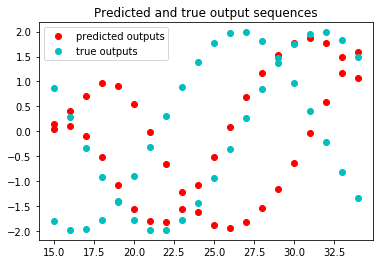

In [61]:
test_seq_input = np.array(generate_samples_for_input(train_data_x[-15:])).transpose(1,0)
test_seq_output = np.array(generate_samples_for_output(train_data_x[-20:])).transpose(1,0)
#-15:
#-20:
plt.title("Predicted and true output sequences")
#i1, i2, i3, = plt.plot(range(15), np.array(true_input_signals(x[95:110])).transpose(1, 0), 'c:', label = 'true input sequence')
p1, p2 = plt.plot(range(15, 35), final_preds, 'ro', label = 'predicted outputs')
t1, t2 = plt.plot(range(15, 35), np.array(true_output_signals(x[110:])).transpose(1, 0 ), 'co', label = 'true outputs')
# transpose (1,0)
#range 15,35
plt.legend(handles = [p1, t1], loc = 'upper left')
plt.show()